# Cat Breed Dataset Statistical Analysis

This notebook provides a comprehensive statistical analysis of the cat breed dataset used in the classification project. We'll explore the distribution of images across breeds, analyze image properties, and visualize samples from the dataset.

## Objectives:
1. Understand the dataset structure and distribution
2. Analyze image dimensions, aspect ratios, and file sizes
3. Visualize sample images from different breeds
4. Identify potential data imbalances or quality issues

The insights from this analysis will help inform preprocessing steps and model design choices for the cat breed classification system.

## 1. Import Required Libraries

Let's import all the necessary libraries for our analysis:

In [5]:
# System libraries
import os
import logging
from pathlib import Path
from typing import Dict, List, Tuple, Any
import random
import json
from collections import Counter

# Data manipulation and analysis
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# Image processing
from PIL import Image
import cv2

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.figure import Figure
from matplotlib.axes import Axes

# Configure the notebook
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Display all columns in pandas DataFrames
pd.set_option('display.max_columns', None)

## 2. Load and Explore Dataset Structure

Let's begin by exploring the structure of our dataset. We'll define the data directory path and inspect the cat breed folders.

In [6]:
# Define the dataset directory path
PROJECT_ROOT = Path(os.getcwd()).parent
DATA_DIR = PROJECT_ROOT / "data" / "data-breed" / "processed"

# Check if the directory exists
if not DATA_DIR.exists():
    logger.error(f"Data directory not found at {DATA_DIR}")
    # Try alternative path
    alt_paths = [
        PROJECT_ROOT / "data" / "processed",
        PROJECT_ROOT / "data" / "data-breed",
    ]
    for alt_path in alt_paths:
        if alt_path.exists():
            DATA_DIR = alt_path
            logger.info(f"Using alternative data directory: {DATA_DIR}")
            break
    else:
        raise FileNotFoundError(f"Data directory not found. Tried paths: {[DATA_DIR] + alt_paths}")

# Function to get dataset structure
def get_dataset_structure(data_dir: Path) -> Dict[str, int]:
    """
    Get the structure of the dataset.
    
    Args:
        data_dir: Path to the data directory
        
    Returns:
        Dictionary mapping breed names to number of images
    """
    breed_counts = {}
    
    # List all directories (breeds)
    breed_dirs = [d for d in data_dir.iterdir() if d.is_dir()]
    
    for breed_dir in breed_dirs:
        breed_name = breed_dir.name
        image_files = [f for f in breed_dir.glob('*') if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]
        breed_counts[breed_name] = len(image_files)
    
    return breed_counts

# Get dataset statistics
breed_counts = get_dataset_structure(DATA_DIR)

# Display basic dataset information
print(f"Total number of breeds: {len(breed_counts)}")
print(f"Total number of images: {sum(breed_counts.values())}")
print(f"Dataset directory: {DATA_DIR}")
print("\nFirst 5 breeds:")
for i, (breed, count) in enumerate(list(breed_counts.items())[:5]):
    print(f"  - {breed}: {count} images")

Total number of breeds: 21
Total number of images: 11050
Dataset directory: d:\Personal\Embeyeu\Study\Hust\IT 3320E - Intro to DL\Capstone Project\data\data-breed\processed

First 5 breeds:
  - Abyssinian: 543 images
  - American Bobtail: 725 images
  - American Curl: 350 images
  - American Shorthair: 725 images
  - Bengal: 525 images


## 3. Count Images per Cat Breed

Let's organize the image counts into a DataFrame for better analysis and create a table showing the distribution of images across breeds.

In [14]:
# Create DataFrame from breed counts
breed_df = pd.DataFrame({
    'Breed': list(breed_counts.keys()),
    'Image_Count': list(breed_counts.values())
}).sort_values('Image_Count', ascending=False).reset_index(drop=True)

# Add percentage column
total_images = breed_df['Image_Count'].sum()
breed_df['Percentage'] = (breed_df['Image_Count'] / total_images * 100).round(2)

# Calculate statistics
min_images = breed_df['Image_Count'].min()
max_images = breed_df['Image_Count'].max()
mean_images = breed_df['Image_Count'].mean()
median_images = breed_df['Image_Count'].median()

# Display summary statistics
print(f"Image count statistics:")
print(f"  - Minimum: {min_images} images")
print(f"  - Maximum: {max_images} images")
print(f"  - Mean: {mean_images:.2f} images")
print(f"  - Median: {median_images:.2f} images")
print(f"\nClass imbalance ratio (max/min): {max_images/min_images:.2f}x")

# Display the table of breeds and their image counts
breed_df.head(21)

Image count statistics:
  - Minimum: 350 images
  - Maximum: 725 images
  - Mean: 526.19 images
  - Median: 525.00 images

Class imbalance ratio (max/min): 2.07x


Breed  Image_Count  Percentage
0     American Bobtail          725        6.56
1   American Shorthair          725        6.56
2           Maine Coon          725        6.56
3    British Shorthair          725        6.56
4         Egyptian Mau          725        6.56
5         Russian Blue          725        6.56
6           Abyssinian          543        4.91
7              Siamese          530        4.80
8               Sphynx          527        4.77
9              Ragdoll          525        4.75
10              Bengal          525        4.75
11              Birman          525        4.75
12              Bombay          525        4.75
13             Persian          525        4.75
14              Tuxedo          375        3.39
15       American Curl          350        3.17
16    Exotic Shorthair          350        3.17
17    Norwegian Forest          350        3.17
18                Manx          350        3.17
19       Scottish Fold          350        3.17
20      Turkish Angora          350        3.17

## 4. Visualize Class Distribution

Let's create visual representations of the class distribution to better understand the dataset balance.

C:\Users\phuongnam-d\AppData\Local\Temp\ipykernel_7360\367484398.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Breed', y='Image_Count', data=breed_df, palette=colors)
C:\Users\phuongnam-d\AppData\Local\Temp\ipykernel_7360\367484398.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


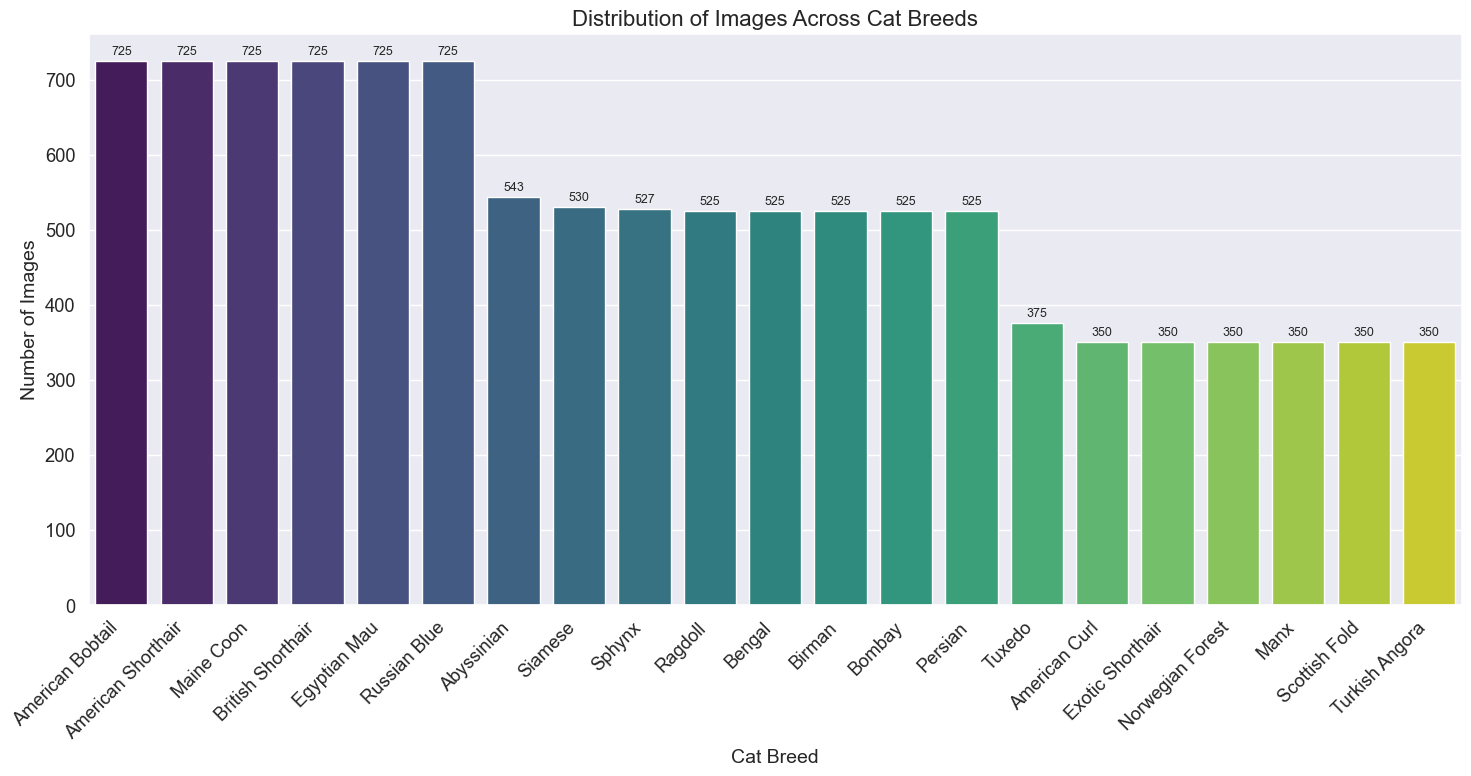

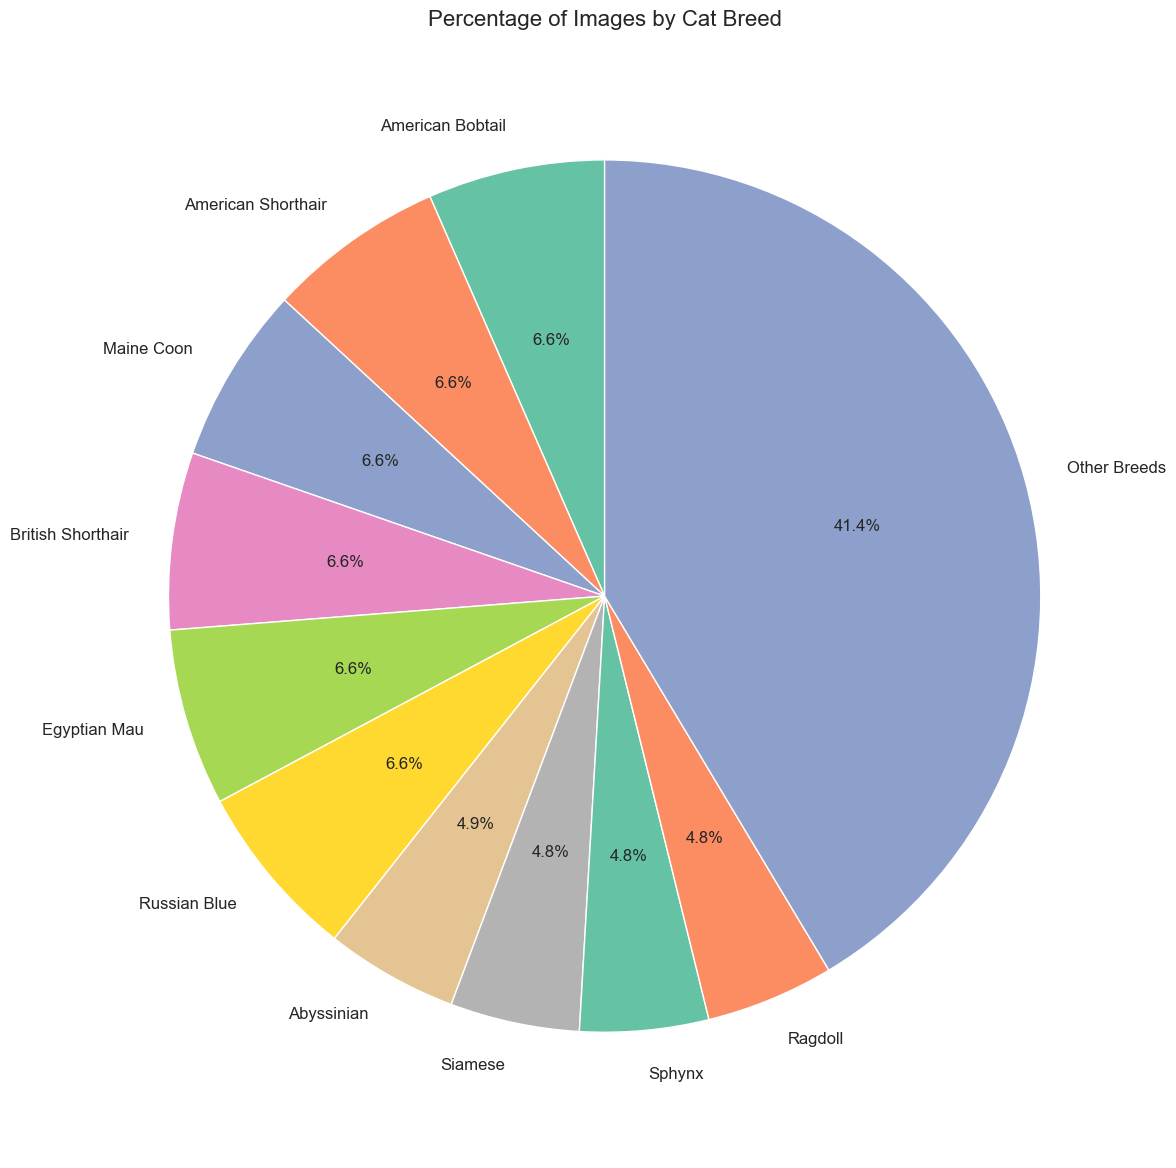

In [15]:
# Set figure size for better visualization
plt.figure(figsize=(15, 8))

# Create color palette that transitions from dark to light
colors = sns.color_palette("viridis", n_colors=len(breed_df))

# Create bar chart
ax = sns.barplot(x='Breed', y='Image_Count', data=breed_df, palette=colors)

# Customize the plot
ax.set_title('Distribution of Images Across Cat Breeds', fontsize=16)
ax.set_xlabel('Cat Breed', fontsize=14)
ax.set_ylabel('Number of Images', fontsize=14)

# Display the breed names at an angle for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

# Add count labels on top of bars
for i, count in enumerate(breed_df['Image_Count']):
    ax.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=9)

# Adjust layout for better viewing
plt.tight_layout()
plt.show()

# Create a pie chart for the distribution
plt.figure(figsize=(12, 12))

# Select top breeds for better visualization (merge small ones into "Other")
top_n = 10
top_breeds = breed_df.head(top_n).copy()
other_breeds = breed_df.iloc[top_n:].copy()

if not other_breeds.empty:
    other_row = pd.DataFrame({
        'Breed': ['Other Breeds'],
        'Image_Count': [other_breeds['Image_Count'].sum()],
        'Percentage': [other_breeds['Percentage'].sum()]
    })
    pie_df = pd.concat([top_breeds, other_row], ignore_index=True)
else:
    pie_df = top_breeds

# Create a custom color palette
pie_colors = sns.color_palette("Set2", n_colors=len(pie_df))

# Plot the pie chart
plt.pie(
    pie_df['Image_Count'], 
    labels=pie_df['Breed'], 
    autopct='%1.1f%%',
    startangle=90,
    colors=pie_colors,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1},
    textprops={'fontsize': 12}
)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
plt.title('Percentage of Images by Cat Breed', fontsize=16)
plt.tight_layout()
plt.show()

## 5. Analyze Image Dimensions and Aspect Ratios

Let's analyze the dimensions, aspect ratios, and file sizes of the images in our dataset. We'll randomly sample images from each breed to get a representative view.

In [16]:
# Function to analyze image properties
def analyze_image_properties(data_dir: Path, n_samples_per_breed: int = 20) -> pd.DataFrame:
    """
    Analyze image properties from the dataset.
    
    Args:
        data_dir: Path to the data directory
        n_samples_per_breed: Number of images to sample from each breed
        
    Returns:
        DataFrame with image properties
    """
    image_properties = []
    
    # List all directories (breeds)
    breed_dirs = [d for d in data_dir.iterdir() if d.is_dir()]
    
    for breed_dir in tqdm(breed_dirs, desc="Analyzing breeds"):
        breed_name = breed_dir.name
        
        # Get all image files
        image_files = list(breed_dir.glob('*.jpg')) + list(breed_dir.glob('*.jpeg')) + list(breed_dir.glob('*.png'))
        
        # Sample images
        samples = min(n_samples_per_breed, len(image_files))
        sampled_images = random.sample(image_files, samples)
        
        # Analyze each sampled image
        for img_path in sampled_images:
            try:
                # Get file size in KB
                file_size_kb = os.path.getsize(img_path) / 1024
                
                # Open image and get dimensions
                with Image.open(img_path) as img:
                    width, height = img.size
                    aspect_ratio = width / height
                    
                # Store the properties
                image_properties.append({
                    'breed': breed_name,
                    'filename': img_path.name,
                    'width': width,
                    'height': height,
                    'aspect_ratio': aspect_ratio,
                    'file_size_kb': file_size_kb
                })
            except Exception as e:
                logger.warning(f"Error analyzing {img_path}: {e}")
    
    return pd.DataFrame(image_properties)

# Get image properties
image_props_df = analyze_image_properties(DATA_DIR, n_samples_per_breed=20)

# Display basic statistics
print("Image Properties Summary:")
print(f"Total sampled images: {len(image_props_df)}")

# Display summary statistics for dimensions
print("\nDimension Statistics:")
print(image_props_df[['width', 'height', 'aspect_ratio', 'file_size_kb']].describe())

# Show first few rows
image_props_df.head()

Analyzing breeds:   0%|          | 0/21 [00:00<?, ?it/s]

Image Properties Summary:
Total sampled images: 420

Dimension Statistics:
             width       height  aspect_ratio  file_size_kb
count   420.000000   420.000000    420.000000    420.000000
mean    453.197619   456.900000      1.074778     62.823765
std     360.512684   376.698223      0.332160    112.999443
min     169.000000   154.000000      0.480120      2.997070
25%     300.000000   249.250000      0.750000     13.179688
50%     300.000000   364.500000      1.038782     19.797363
75%     474.000000   484.500000      1.333333     76.326172
max    2048.000000  2048.000000      1.948052   1004.740234


breed                     filename  width  height  aspect_ratio  \
0  Abyssinian           Abyssinian_118.jpg    300     225      1.333333   
1  Abyssinian  Abyssinian-44006447_120.jpg    300     400      0.750000   
2  Abyssinian           Abyssinian_341.jpg    300     400      0.750000   
3  Abyssinian           Abyssinian_284.jpg    500     359      1.392758   
4  Abyssinian  Abyssinian-42473567_149.jpg    300     420      0.714286   

   file_size_kb  
0     14.991211  
1     21.187500  
2     14.855469  
3     87.247070  
4     11.976562

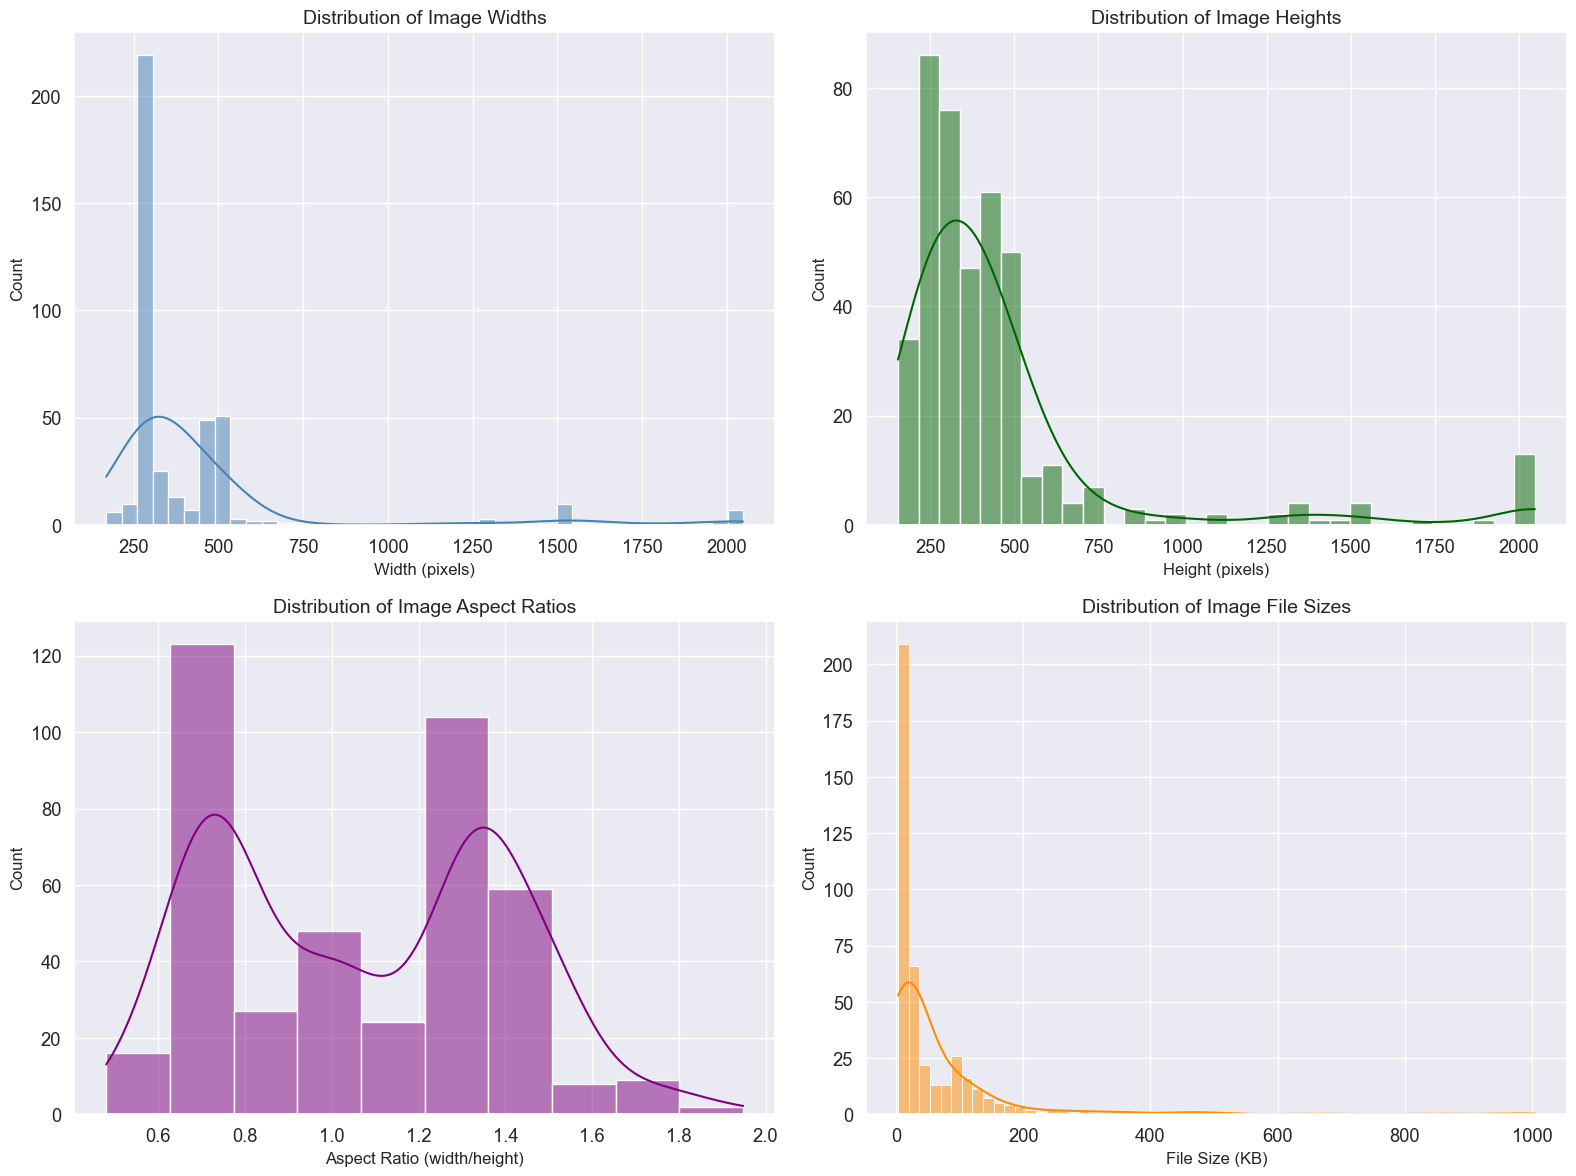

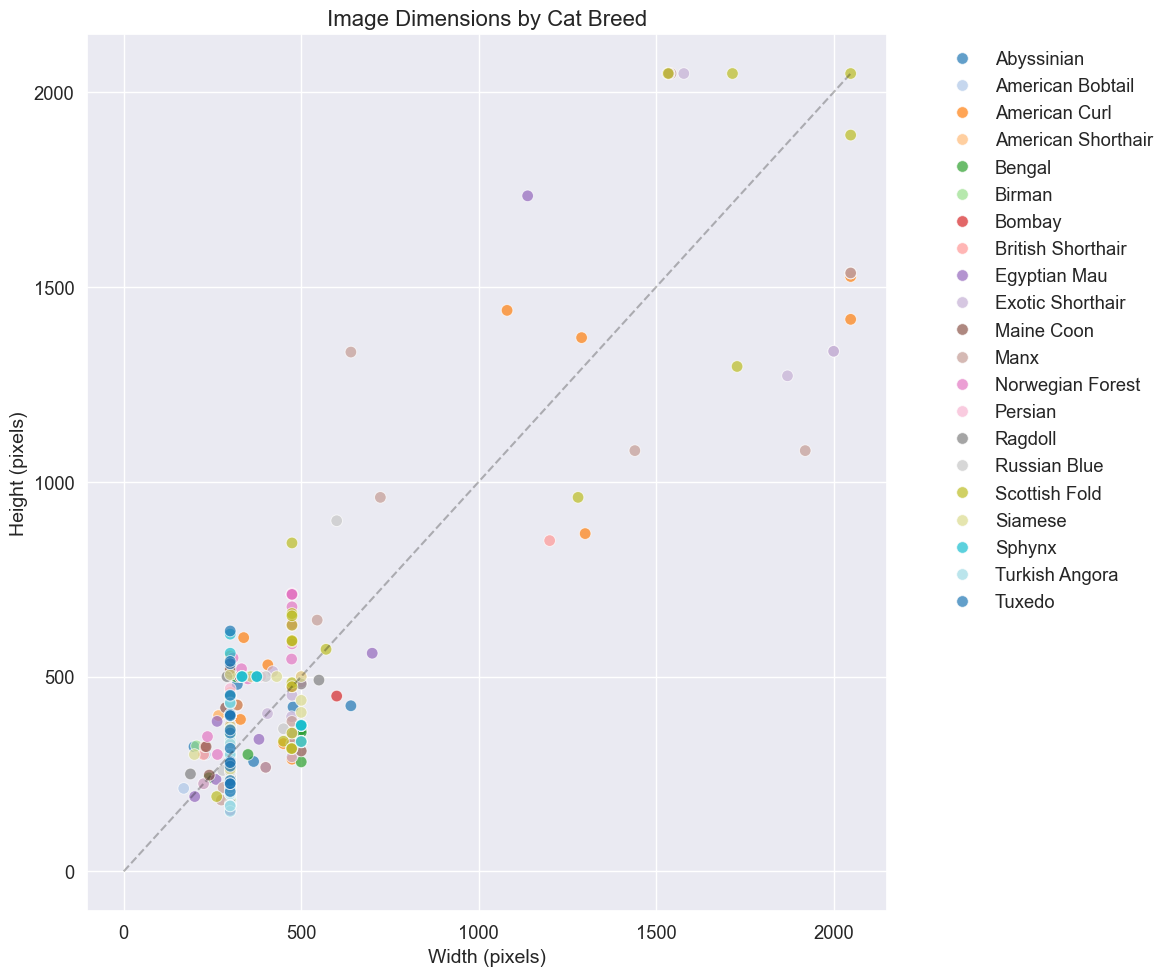

C:\Users\phuongnam-d\AppData\Local\Temp\ipykernel_7360\4103432546.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


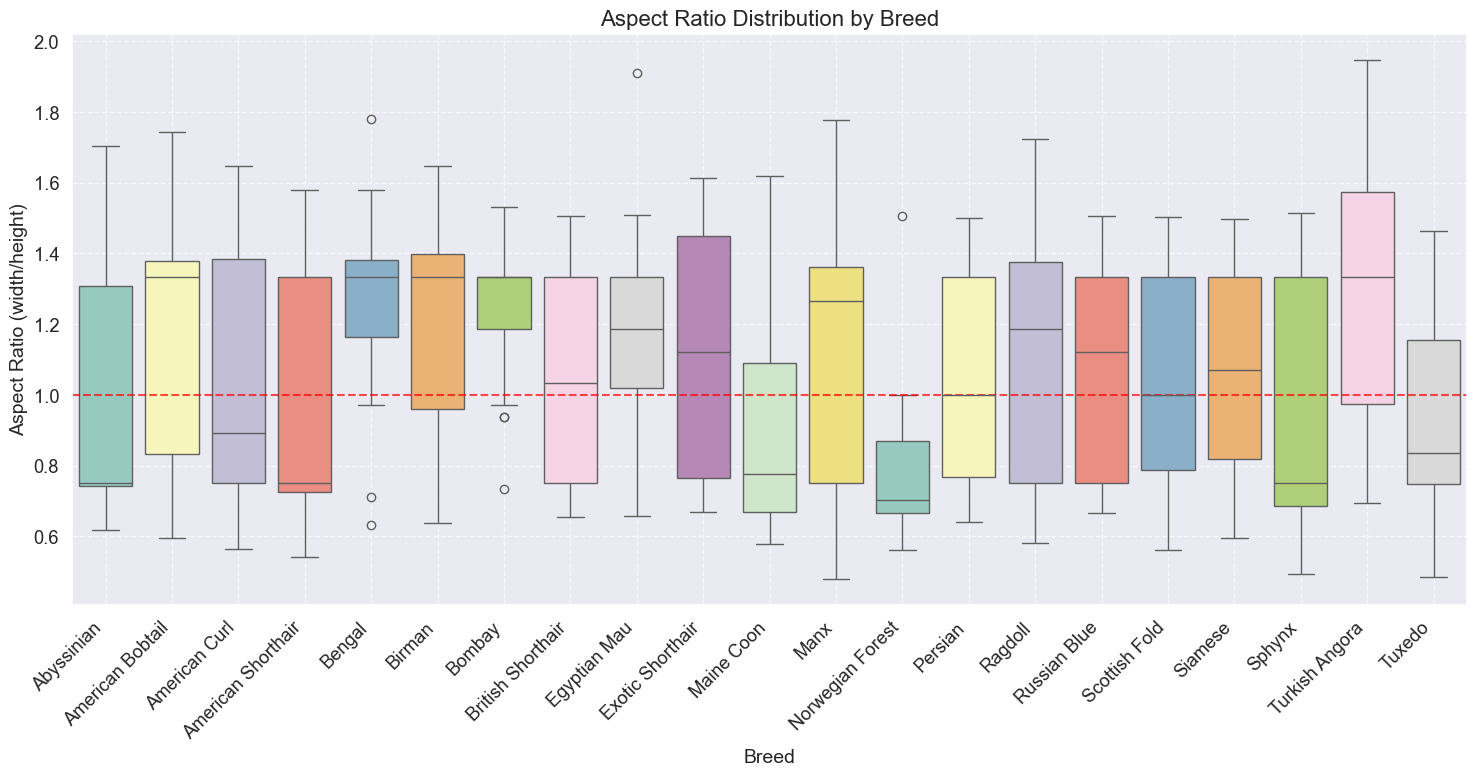

In [17]:
# Create a figure with multiple plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Define a common color palette
palette = "viridis"

# Plot 1: Width distribution
sns.histplot(data=image_props_df, x='width', kde=True, ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Distribution of Image Widths', fontsize=14)
axes[0, 0].set_xlabel('Width (pixels)', fontsize=12)
axes[0, 0].set_ylabel('Count', fontsize=12)

# Plot 2: Height distribution
sns.histplot(data=image_props_df, x='height', kde=True, ax=axes[0, 1], color='darkgreen')
axes[0, 1].set_title('Distribution of Image Heights', fontsize=14)
axes[0, 1].set_xlabel('Height (pixels)', fontsize=12)
axes[0, 1].set_ylabel('Count', fontsize=12)

# Plot 3: Aspect ratio distribution
sns.histplot(data=image_props_df, x='aspect_ratio', kde=True, ax=axes[1, 0], color='purple')
axes[1, 0].set_title('Distribution of Image Aspect Ratios', fontsize=14)
axes[1, 0].set_xlabel('Aspect Ratio (width/height)', fontsize=12)
axes[1, 0].set_ylabel('Count', fontsize=12)

# Plot 4: File size distribution
sns.histplot(data=image_props_df, x='file_size_kb', kde=True, ax=axes[1, 1], color='darkorange')
axes[1, 1].set_title('Distribution of Image File Sizes', fontsize=14)
axes[1, 1].set_xlabel('File Size (KB)', fontsize=12)
axes[1, 1].set_ylabel('Count', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()

# Create a scatter plot of width vs height colored by breed
plt.figure(figsize=(12, 10))
scatter = sns.scatterplot(
    data=image_props_df, 
    x='width', 
    y='height',
    hue='breed',
    s=70,  # Marker size
    alpha=0.7,  # Transparency
    palette='tab20'  # Colormap
)

# Add labels
plt.title('Image Dimensions by Cat Breed', fontsize=16)
plt.xlabel('Width (pixels)', fontsize=14)
plt.ylabel('Height (pixels)', fontsize=14)

# Improve legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)

# Add a reference line for square images
plt.plot([0, max(image_props_df['width'].max(), image_props_df['height'].max())], 
         [0, max(image_props_df['width'].max(), image_props_df['height'].max())], 
         'k--', alpha=0.3, label='Square (1:1)')

plt.tight_layout()
plt.show()

# Create a boxplot showing aspect ratio by breed
plt.figure(figsize=(15, 8))
sns.boxplot(
    data=image_props_df,
    x='breed',
    y='aspect_ratio',
    palette='Set3'
)

# Customize the plot
plt.title('Aspect Ratio Distribution by Breed', fontsize=16)
plt.xlabel('Breed', fontsize=14)
plt.ylabel('Aspect Ratio (width/height)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.axhline(y=1, color='red', linestyle='--', alpha=0.7)  # Reference line for square images
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 6. Visualize Sample Images per Breed

Let's visualize sample images from different breeds to better understand the dataset's visual characteristics.

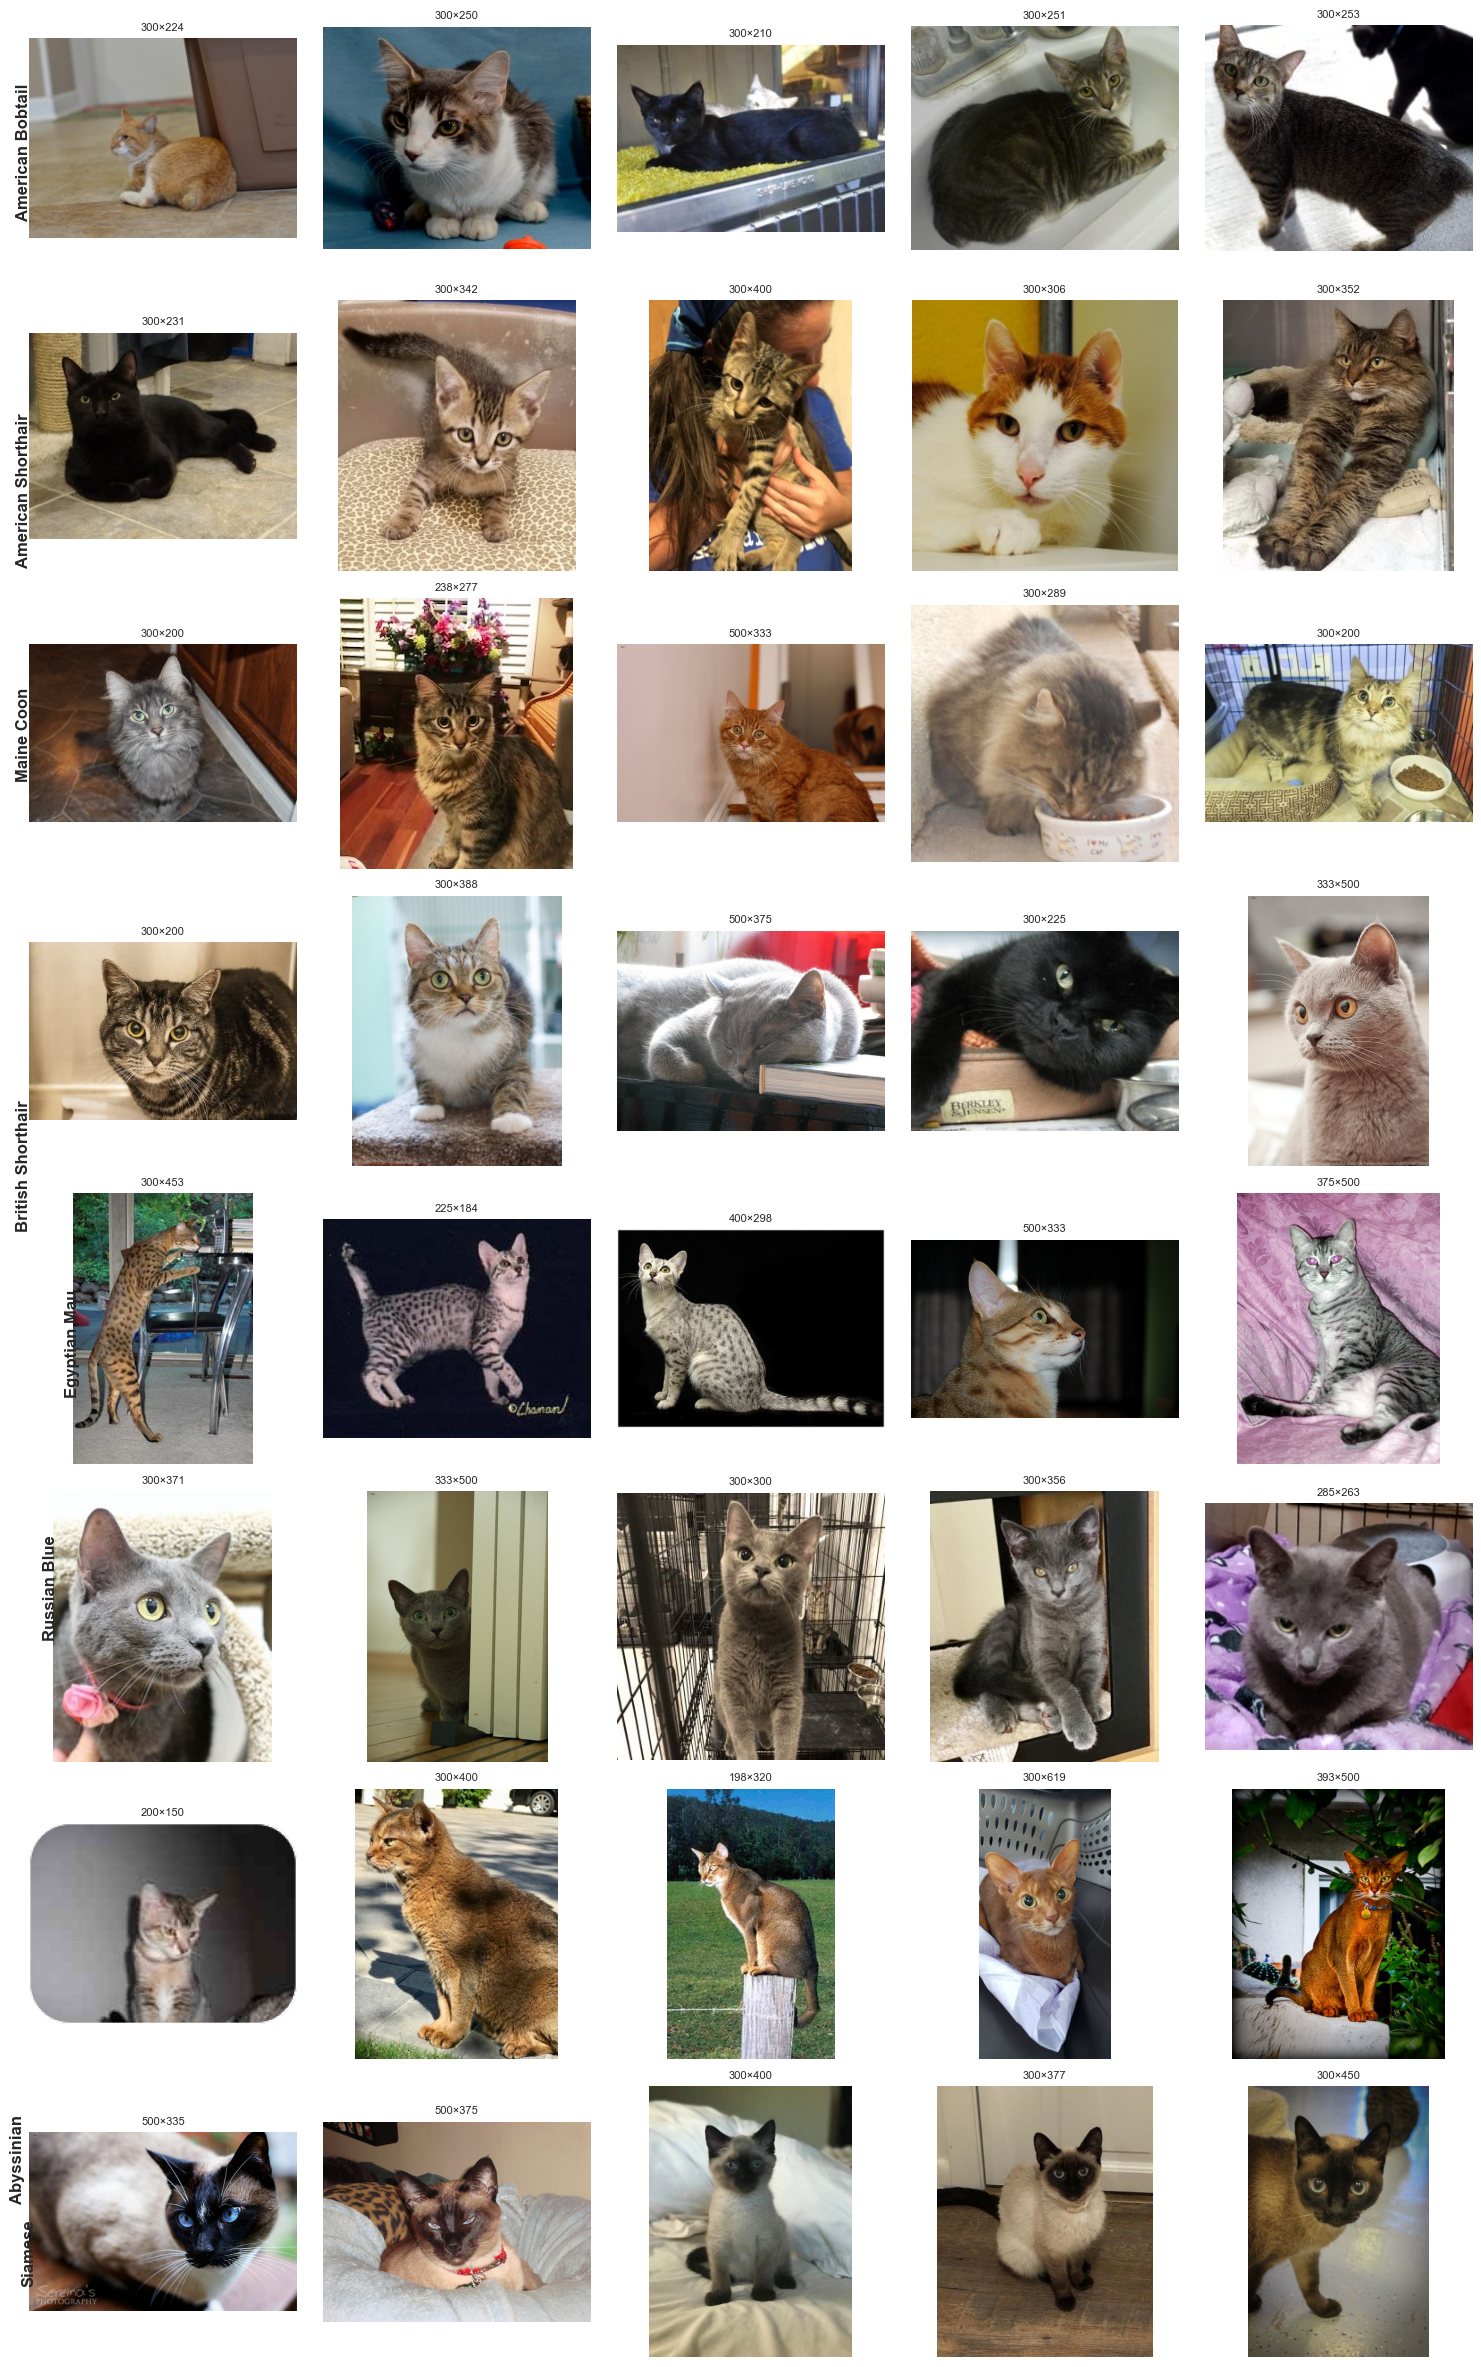

In [18]:
# Function to display sample images from each breed
def display_sample_images(data_dir: Path, breeds_to_show: List[str] = None, samples_per_breed: int = 5) -> None:
    """
    Display sample images from selected breeds.
    
    Args:
        data_dir: Path to the data directory
        breeds_to_show: List of breed names to display (if None, will use all breeds)
        samples_per_breed: Number of samples to show per breed
    """
    # If no breeds specified, use all
    if breeds_to_show is None:
        # Get all breed directories
        breed_dirs = [d for d in data_dir.iterdir() if d.is_dir()]
        breeds_to_show = [d.name for d in breed_dirs]
    else:
        # Filter to ensure all specified breeds exist
        breed_dirs = []
        for breed in breeds_to_show:
            breed_path = data_dir / breed
            if breed_path.exists() and breed_path.is_dir():
                breed_dirs.append(breed_path)
            else:
                logger.warning(f"Breed directory not found: {breed}")
    
    # Limit number of breeds if too many
    max_breeds = 8
    if len(breeds_to_show) > max_breeds:
        logger.info(f"Limiting display to {max_breeds} randomly selected breeds")
        random.shuffle(breeds_to_show)
        breeds_to_show = breeds_to_show[:max_breeds]
    
    # Create figure with subplots
    n_breeds = len(breeds_to_show)
    fig, axes = plt.subplots(n_breeds, samples_per_breed, figsize=(samples_per_breed * 3, n_breeds * 3))
    
    # If only one breed, make axes 2D
    if n_breeds == 1:
        axes = axes.reshape(1, -1)
    
    # Loop through each breed
    for i, breed in enumerate(breeds_to_show):
        breed_path = data_dir / breed
        
        # Get image files
        image_files = list(breed_path.glob('*.jpg')) + list(breed_path.glob('*.jpeg')) + list(breed_path.glob('*.png'))
        
        # Ensure we have enough samples
        if len(image_files) < samples_per_breed:
            logger.warning(f"Not enough images for {breed}. Only {len(image_files)} available.")
            selected_images = image_files
        else:
            selected_images = random.sample(image_files, samples_per_breed)
        
        # Display each sample
        for j, img_path in enumerate(selected_images):
            if j < samples_per_breed:  # Safeguard
                # Read image
                img = cv2.imread(str(img_path))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                
                # Display
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
                
                # Add resolution info
                height, width = img.shape[:2]
                axes[i, j].set_title(f"{width}×{height}", fontsize=8)
            
        # Add breed name to the first plot in the row
        if selected_images:
            axes[i, 0].text(-15, img.shape[0] // 2, breed, rotation=90, 
                           verticalalignment='center', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

# Select a subset of breeds to display (or use None to show all)
selected_breeds = list(breed_df['Breed'].head(8))  # Top 8 breeds by image count

# Display sample images
display_sample_images(DATA_DIR, breeds_to_show=selected_breeds, samples_per_breed=5)

## 7. Cat Emotion Dataset Analysis

Now let's analyze the cat emotion dataset to understand the distribution and characteristics of emotional expressions in cats.

In [7]:
# Define the emotion dataset directory path
PROJECT_ROOT = Path(os.getcwd()).parent
EMOTION_DATA_DIR = PROJECT_ROOT / "data" / "data-emo" / "processed"

# Check if the directory exists
if not EMOTION_DATA_DIR.exists():
    logger.error(f"Emotion data directory not found at {EMOTION_DATA_DIR}")
    print(f"Emotion data directory not found at {EMOTION_DATA_DIR}")
else:
    # Get emotion dataset statistics
    emotion_counts = get_dataset_structure(EMOTION_DATA_DIR)
    
    # Display basic emotion dataset information
    print("🎭 CAT EMOTION DATASET ANALYSIS 🎭")
    print("=" * 50)
    print(f"Total number of emotion categories: {len(emotion_counts)}")
    print(f"Total number of emotion images: {sum(emotion_counts.values())}")
    print(f"Emotion dataset directory: {EMOTION_DATA_DIR}")
    print("\nEmotion categories and counts:")
    for emotion, count in emotion_counts.items():
        print(f"  - {emotion}: {count} images")
    
    # Create DataFrame for emotion analysis
    emotion_df = pd.DataFrame({
        'Emotion': list(emotion_counts.keys()),
        'Image_Count': list(emotion_counts.values())
    }).sort_values('Image_Count', ascending=False).reset_index(drop=True)
    
    # Add percentage column
    total_emotion_images = emotion_df['Image_Count'].sum()
    emotion_df['Percentage'] = (emotion_df['Image_Count'] / total_emotion_images * 100).round(2)
    
    # Calculate emotion statistics
    min_emotion_images = emotion_df['Image_Count'].min()
    max_emotion_images = emotion_df['Image_Count'].max()
    mean_emotion_images = emotion_df['Image_Count'].mean()
    median_emotion_images = emotion_df['Image_Count'].median()
    
    print(f"\nEmotion dataset statistics:")
    print(f"  - Minimum: {min_emotion_images} images")
    print(f"  - Maximum: {max_emotion_images} images")
    print(f"  - Mean: {mean_emotion_images:.2f} images")
    print(f"  - Median: {median_emotion_images:.2f} images")
    print(f"  - Class imbalance ratio (max/min): {max_emotion_images/min_emotion_images:.2f}x")
    
    # Display the emotion dataframe
    emotion_df

🎭 CAT EMOTION DATASET ANALYSIS 🎭
Total number of emotion categories: 4
Total number of emotion images: 1000
Emotion dataset directory: d:\Personal\Embeyeu\Study\Hust\IT 3320E - Intro to DL\Capstone Project\data\data-emo\processed

Emotion categories and counts:
  - Angry: 250 images
  - happy: 250 images
  - Other: 250 images
  - Sad: 250 images

Emotion dataset statistics:
  - Minimum: 250 images
  - Maximum: 250 images
  - Mean: 250.00 images
  - Median: 250.00 images
  - Class imbalance ratio (max/min): 1.00x


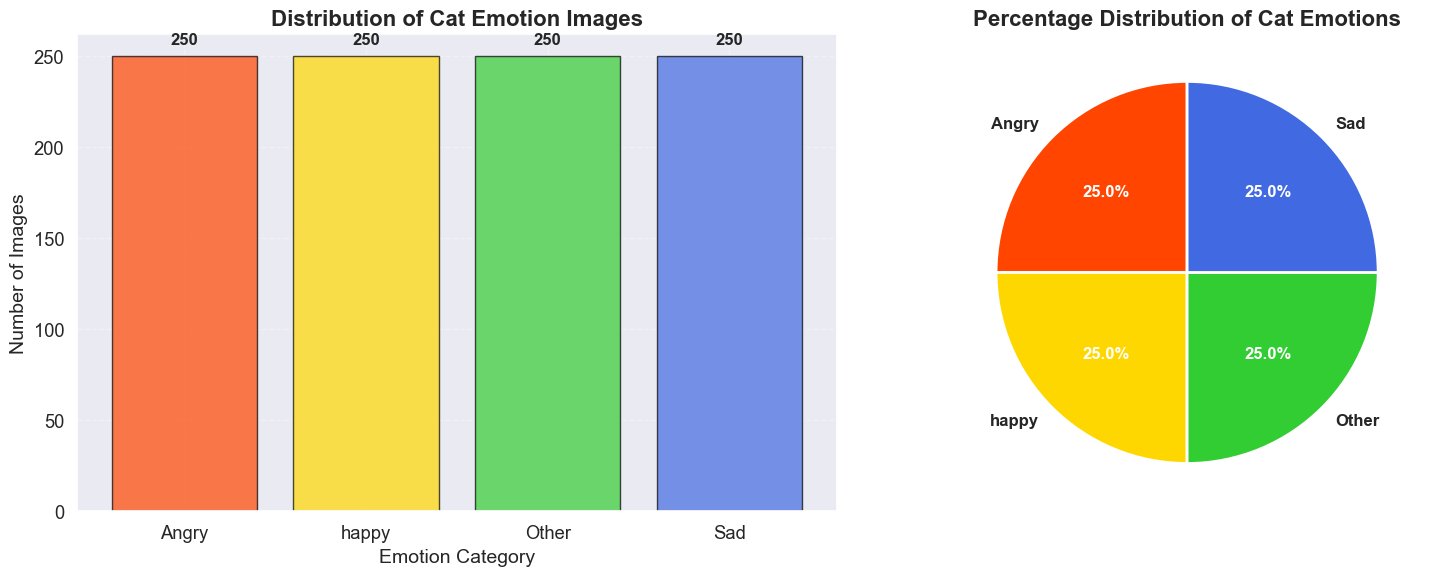

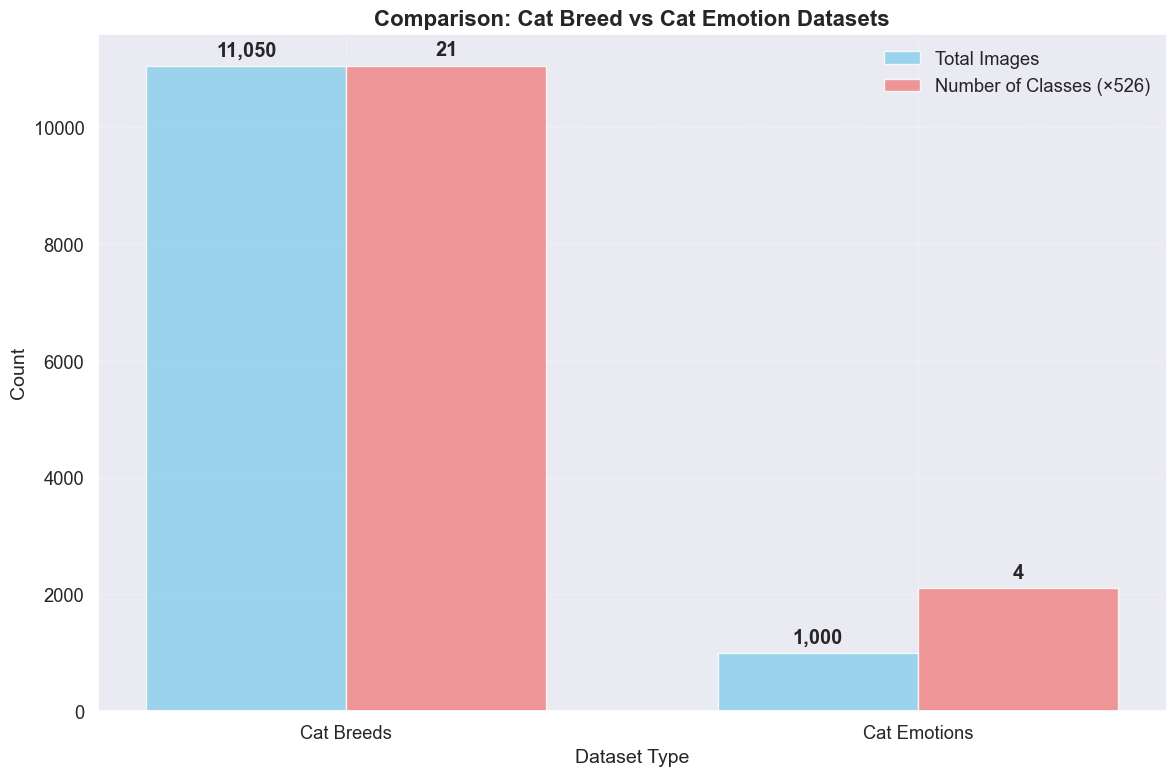

In [19]:
# Visualize emotion dataset distribution
if EMOTION_DATA_DIR.exists():
    # Create a figure with emotion distribution plots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Define emotion colors
    emotion_colors = {
        'happy': '#FFD700',    # Gold
        'Angry': '#FF4500',    # Red-Orange
        'Sad': '#4169E1',      # Royal Blue
        'Other': '#32CD32'     # Lime Green
    }
    
    # Create color list based on emotion names
    colors = [emotion_colors.get(emotion, '#808080') for emotion in emotion_df['Emotion']]
    
    # Plot 1: Bar chart
    bars = axes[0].bar(emotion_df['Emotion'], emotion_df['Image_Count'], color=colors, alpha=0.7, edgecolor='black')
    axes[0].set_title('Distribution of Cat Emotion Images', fontsize=16, fontweight='bold')
    axes[0].set_xlabel('Emotion Category', fontsize=14)
    axes[0].set_ylabel('Number of Images', fontsize=14)
    
    # Add count labels on top of bars
    for bar, count in zip(bars, emotion_df['Image_Count']):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                    str(count), ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Add grid for better readability
    axes[0].grid(True, linestyle='--', alpha=0.3)
    
    # Plot 2: Pie chart
    wedges, texts, autotexts = axes[1].pie(
        emotion_df['Image_Count'], 
        labels=emotion_df['Emotion'], 
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        wedgeprops={'edgecolor': 'white', 'linewidth': 2},
        textprops={'fontsize': 12, 'fontweight': 'bold'}
    )
    
    # Enhance pie chart text
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    axes[1].set_title('Percentage Distribution of Cat Emotions', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Create a comparison chart between breed and emotion datasets
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Compare dataset sizes
    dataset_comparison = pd.DataFrame({
        'Dataset': ['Cat Breeds', 'Cat Emotions'],
        'Total_Images': [breed_df['Image_Count'].sum(), emotion_df['Image_Count'].sum()],
        'Number_of_Classes': [len(breed_df), len(emotion_df)]
    })
    
    # Create grouped bar chart
    x = np.arange(len(dataset_comparison['Dataset']))
    width = 0.35
    
    # Normalize the values for better comparison
    max_images = max(dataset_comparison['Total_Images'])
    max_classes = max(dataset_comparison['Number_of_Classes'])
    
    bars1 = ax.bar(x - width/2, dataset_comparison['Total_Images'], width, 
                   label='Total Images', color='skyblue', alpha=0.8)
    bars2 = ax.bar(x + width/2, dataset_comparison['Number_of_Classes'] * (max_images/max_classes), width,
                   label=f'Number of Classes (×{max_images//max_classes})', color='lightcoral', alpha=0.8)
    
    ax.set_xlabel('Dataset Type', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax.set_title('Comparison: Cat Breed vs Cat Emotion Datasets', fontsize=16, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(dataset_comparison['Dataset'])
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + max_images*0.01,
                f'{int(height):,}', ha='center', va='bottom', fontweight='bold')
    
    for bar, actual_value in zip(bars2, dataset_comparison['Number_of_Classes']):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + max_images*0.01,
                f'{actual_value}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

Analyzing breeds:   0%|          | 0/4 [00:00<?, ?it/s]

🎭 EMOTION IMAGE PROPERTIES ANALYSIS 🎭
Total sampled emotion images: 200

Emotion Image Dimension Statistics:
            width      height  aspect_ratio  file_size_kb
count  200.000000  200.000000         200.0    200.000000
mean   206.675000  206.675000           1.0     18.674253
std     21.951737   21.951737           0.0      5.380510
min    179.000000  179.000000           1.0      9.163086
25%    179.000000  179.000000           1.0     14.407959
50%    224.000000  224.000000           1.0     18.155762
75%    224.000000  224.000000           1.0     21.714355
max    224.000000  224.000000           1.0     35.330078


C:\Users\phuongnam-d\AppData\Local\Temp\ipykernel_7360\3612362236.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=emotion_props_df, x='breed', y='width',
C:\Users\phuongnam-d\AppData\Local\Temp\ipykernel_7360\3612362236.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=emotion_props_df, x='breed', y='height',
C:\Users\phuongnam-d\AppData\Local\Temp\ipykernel_7360\3612362236.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=emotion_props_df, x='breed', y='aspect_ratio',
C:\Users\phuongnam-d\AppData\Local\Temp\ipyk

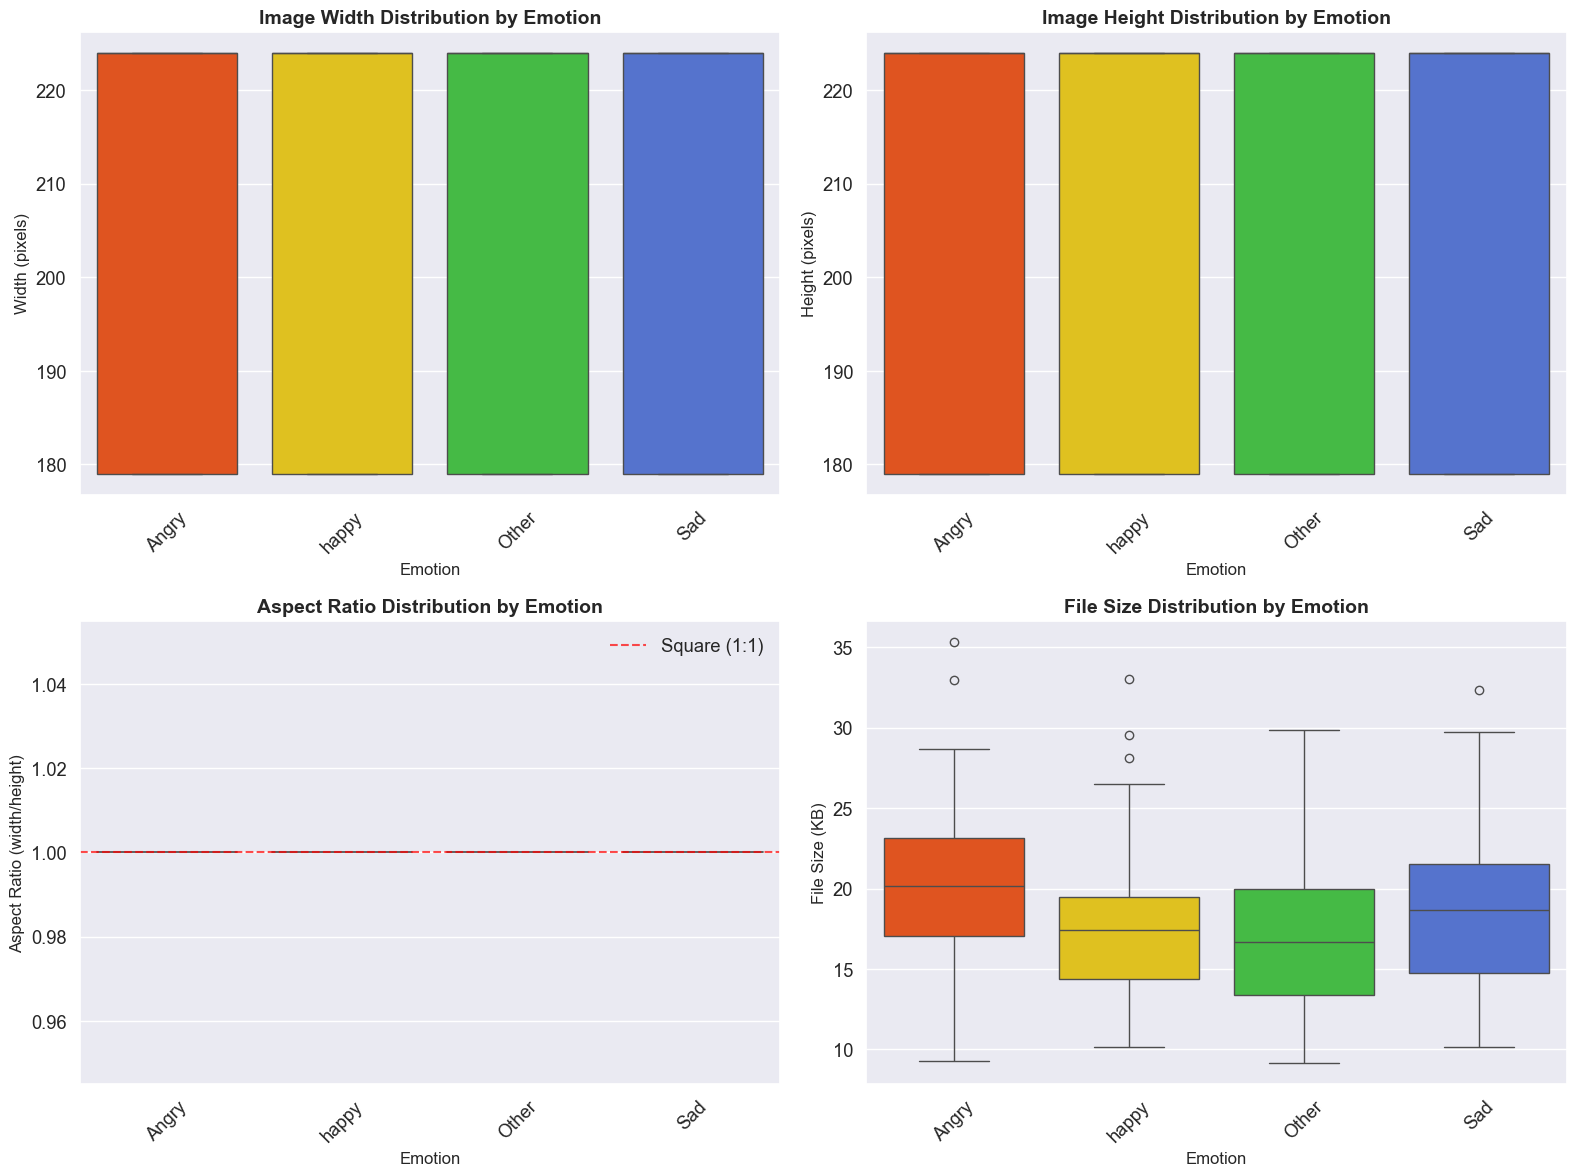


Sample Emotion Image Properties:


In [20]:
# Analyze emotion image properties
if EMOTION_DATA_DIR.exists():
    # Get emotion image properties using the same function
    emotion_props_df = analyze_image_properties(EMOTION_DATA_DIR, n_samples_per_breed=50)
    
    # Display basic statistics for emotion images
    print("🎭 EMOTION IMAGE PROPERTIES ANALYSIS 🎭")
    print("=" * 55)
    print(f"Total sampled emotion images: {len(emotion_props_df)}")
    
    # Display summary statistics for emotion image dimensions
    print("\nEmotion Image Dimension Statistics:")
    print(emotion_props_df[['width', 'height', 'aspect_ratio', 'file_size_kb']].describe())
    
    # Create visualization for emotion image properties
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Define emotion color mapping for consistency
    emotion_palette = {
        'happy': '#FFD700',    # Gold
        'Angry': '#FF4500',    # Red-Orange  
        'Sad': '#4169E1',      # Royal Blue
        'Other': '#32CD32'     # Lime Green
    }
    
    # Plot 1: Width distribution by emotion
    sns.boxplot(data=emotion_props_df, x='breed', y='width', 
                palette=[emotion_palette.get(emotion, '#808080') for emotion in emotion_props_df['breed'].unique()],
                ax=axes[0, 0])
    axes[0, 0].set_title('Image Width Distribution by Emotion', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Emotion', fontsize=12)
    axes[0, 0].set_ylabel('Width (pixels)', fontsize=12)
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Height distribution by emotion
    sns.boxplot(data=emotion_props_df, x='breed', y='height',
                palette=[emotion_palette.get(emotion, '#808080') for emotion in emotion_props_df['breed'].unique()],
                ax=axes[0, 1])
    axes[0, 1].set_title('Image Height Distribution by Emotion', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Emotion', fontsize=12)
    axes[0, 1].set_ylabel('Height (pixels)', fontsize=12)
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Plot 3: Aspect ratio distribution by emotion
    sns.violinplot(data=emotion_props_df, x='breed', y='aspect_ratio',
                   palette=[emotion_palette.get(emotion, '#808080') for emotion in emotion_props_df['breed'].unique()],
                   ax=axes[1, 0])
    axes[1, 0].set_title('Aspect Ratio Distribution by Emotion', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Emotion', fontsize=12)
    axes[1, 0].set_ylabel('Aspect Ratio (width/height)', fontsize=12)
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Square (1:1)')
    axes[1, 0].legend()
    
    # Plot 4: File size distribution by emotion
    sns.boxplot(data=emotion_props_df, x='breed', y='file_size_kb',
                palette=[emotion_palette.get(emotion, '#808080') for emotion in emotion_props_df['breed'].unique()],
                ax=axes[1, 1])
    axes[1, 1].set_title('File Size Distribution by Emotion', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Emotion', fontsize=12)
    axes[1, 1].set_ylabel('File Size (KB)', fontsize=12)
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Show first few rows of emotion properties
    print("\nSample Emotion Image Properties:")
    emotion_props_df.head(10)

🎭 SAMPLE EMOTION IMAGES 🎭


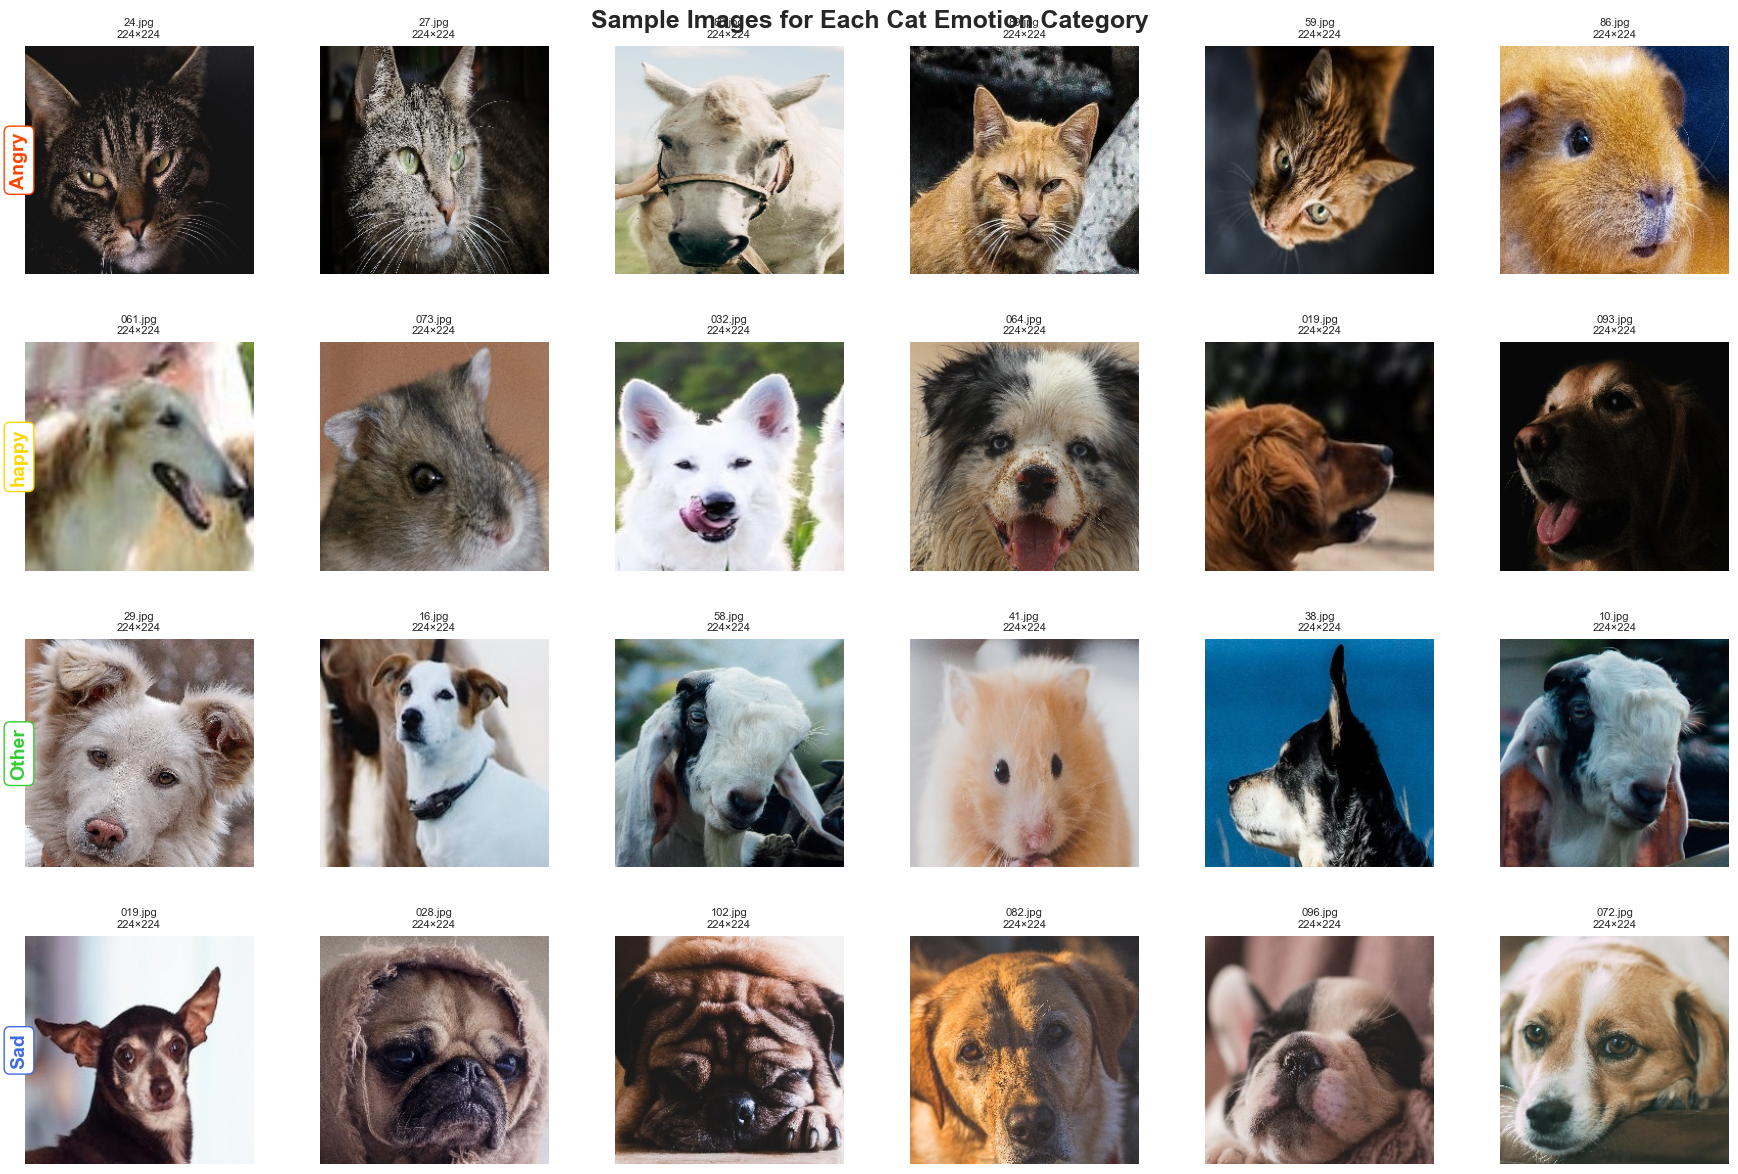


📊 DATASET COMPARISON SUMMARY 📊


In [21]:
# Display sample emotion images
if EMOTION_DATA_DIR.exists():
    print("🎭 SAMPLE EMOTION IMAGES 🎭")
    print("=" * 35)
    
    # Get all emotion categories
    emotion_categories = list(emotion_df['Emotion'])
    
    # Create figure with subplots for emotion samples
    samples_per_emotion = 6
    fig, axes = plt.subplots(len(emotion_categories), samples_per_emotion, 
                            figsize=(samples_per_emotion * 3, len(emotion_categories) * 3))
    
    # If only one emotion category, make axes 2D
    if len(emotion_categories) == 1:
        axes = axes.reshape(1, -1)
    
    # Loop through each emotion category
    for i, emotion in enumerate(emotion_categories):
        emotion_path = EMOTION_DATA_DIR / emotion
        
        # Get image files
        image_files = list(emotion_path.glob('*.jpg')) + list(emotion_path.glob('*.jpeg')) + list(emotion_path.glob('*.png'))
        
        # Filter out augmented images for cleaner samples (prefer original images)
        original_images = [img for img in image_files if not img.name.startswith('aug-')]
        
        # If we don't have enough original images, use all images
        if len(original_images) < samples_per_emotion:
            selected_images = random.sample(image_files, min(samples_per_emotion, len(image_files)))
        else:
            selected_images = random.sample(original_images, samples_per_emotion)
        
        # Display each sample
        for j, img_path in enumerate(selected_images):
            if j < samples_per_emotion:  # Safeguard
                try:
                    # Read image
                    img = cv2.imread(str(img_path))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                    
                    # Display
                    axes[i, j].imshow(img)
                    axes[i, j].axis('off')
                    
                    # Add resolution info and filename
                    height, width = img.shape[:2]
                    axes[i, j].set_title(f"{img_path.name}\n{width}×{height}", fontsize=8)
                except Exception as e:
                    # If image fails to load, show a placeholder
                    axes[i, j].text(0.5, 0.5, f"Error loading\n{img_path.name}", 
                                   ha='center', va='center', transform=axes[i, j].transAxes)
                    axes[i, j].axis('off')
        
        # Add emotion name to the first plot in the row
        if selected_images:
            # Use emotion color scheme
            emotion_color = emotion_palette.get(emotion, '#000000')
            axes[i, 0].text(-15, img.shape[0] // 2, emotion, rotation=90, 
                           verticalalignment='center', fontsize=14, fontweight='bold',
                           color=emotion_color, bbox=dict(boxstyle="round,pad=0.3", 
                                                         facecolor='white', edgecolor=emotion_color))
    
    plt.suptitle('Sample Images for Each Cat Emotion Category', fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.3, top=0.95)
    plt.show()
    
    # Create a summary comparison table
    comparison_data = []
    
    # Add breed dataset info
    comparison_data.append({
        'Dataset': 'Cat Breeds',
        'Categories': len(breed_df),
        'Total Images': breed_df['Image_Count'].sum(),
        'Avg Images per Category': breed_df['Image_Count'].mean(),
        'Min Images': breed_df['Image_Count'].min(),
        'Max Images': breed_df['Image_Count'].max(),
        'Imbalance Ratio': breed_df['Image_Count'].max() / breed_df['Image_Count'].min()
    })
    
    # Add emotion dataset info
    comparison_data.append({
        'Dataset': 'Cat Emotions',
        'Categories': len(emotion_df),
        'Total Images': emotion_df['Image_Count'].sum(),
        'Avg Images per Category': emotion_df['Image_Count'].mean(),
        'Min Images': emotion_df['Image_Count'].min(),
        'Max Images': emotion_df['Image_Count'].max(),
        'Imbalance Ratio': emotion_df['Image_Count'].max() / emotion_df['Image_Count'].min()
    })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("\n📊 DATASET COMPARISON SUMMARY 📊")
    print("=" * 45)
    comparison_df

## 8. Emotion Analysis Conclusions and Recommendations

Based on the analysis of both the cat breed and cat emotion datasets, here are the key findings and recommendations:

In [22]:
# Generate comprehensive analysis for both datasets
if EMOTION_DATA_DIR.exists():
    
    # Emotion-specific analysis
    emotion_imbalance = emotion_df['Image_Count'].max() / emotion_df['Image_Count'].min()
    emotion_std_percentage = emotion_df['Image_Count'].std() / emotion_df['Image_Count'].mean() * 100
    
    # Emotion image dimension analysis
    emotion_mean_width = emotion_props_df['width'].mean()
    emotion_mean_height = emotion_props_df['height'].mean()
    emotion_mean_aspect = emotion_props_df['aspect_ratio'].mean()
    emotion_std_aspect = emotion_props_df['aspect_ratio'].std()
    
    print("🔍 COMPREHENSIVE DATASET ANALYSIS 🔍")
    print("=" * 50)
    
    print("\n📈 CAT BREED DATASET INSIGHTS:")
    print(f"• {len(breed_df)} breed categories with {breed_df['Image_Count'].sum():,} total images")
    print(f"• Class imbalance: {breed_df['Image_Count'].max()/breed_df['Image_Count'].min():.1f}x ratio")
    print(f"• Average image size: {image_props_df['width'].mean():.0f}×{image_props_df['height'].mean():.0f} pixels")
    print(f"• Aspect ratio variability: {image_props_df['aspect_ratio'].std():.2f} std deviation")
    
    print(f"\n🎭 CAT EMOTION DATASET INSIGHTS:")
    print(f"• {len(emotion_df)} emotion categories with {emotion_df['Image_Count'].sum():,} total images")
    print(f"• Class imbalance: {emotion_imbalance:.1f}x ratio")
    print(f"• Average image size: {emotion_mean_width:.0f}×{emotion_mean_height:.0f} pixels")
    print(f"• Aspect ratio variability: {emotion_std_aspect:.2f} std deviation")
    
    # Identify which dataset has better balance
    breed_balance_score = 1 / (breed_df['Image_Count'].max()/breed_df['Image_Count'].min())
    emotion_balance_score = 1 / emotion_imbalance
    
    print(f"\n⚖️ DATASET BALANCE COMPARISON:")
    print(f"• Breed dataset balance score: {breed_balance_score:.3f}")
    print(f"• Emotion dataset balance score: {emotion_balance_score:.3f}")
    print(f"• {'Emotion' if emotion_balance_score > breed_balance_score else 'Breed'} dataset is more balanced")
    
    print(f"\n🎯 RECOMMENDATIONS:")
    
    recommendations = [
        "**Multi-Task Learning**: Consider training a multi-task model that can predict both breed and emotion simultaneously",
        "**Transfer Learning**: Use the breed classification model as a feature extractor for emotion classification",
        "**Data Augmentation**: Apply more aggressive augmentation to emotion dataset due to smaller size",
        "**Cross-Dataset Validation**: Test breed models on emotion data and vice versa for robustness",
        "**Ensemble Methods**: Combine predictions from both specialized models for comprehensive cat analysis",
        "**Attention Mechanisms**: Use attention to focus on different facial features for emotion vs breed classification"
    ]
    
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}")
    
    print(f"\n📊 DATASET STATISTICS SUMMARY:")
    
    # Create final summary statistics
    summary_stats = {
        'Metric': [
            'Total Categories',
            'Total Images', 
            'Largest Class Size',
            'Smallest Class Size',
            'Mean Class Size',
            'Class Imbalance Ratio',
            'Standard Deviation (%)',
            'Mean Image Width',
            'Mean Image Height',
            'Mean Aspect Ratio'
        ],
        'Cat Breeds': [
            len(breed_df),
            breed_df['Image_Count'].sum(),
            breed_df['Image_Count'].max(),
            breed_df['Image_Count'].min(),
            f"{breed_df['Image_Count'].mean():.1f}",
            f"{breed_df['Image_Count'].max()/breed_df['Image_Count'].min():.1f}x",
            f"{breed_df['Image_Count'].std()/breed_df['Image_Count'].mean()*100:.1f}%",
            f"{image_props_df['width'].mean():.0f}px",
            f"{image_props_df['height'].mean():.0f}px",
            f"{image_props_df['aspect_ratio'].mean():.2f}"
        ],
        'Cat Emotions': [
            len(emotion_df),
            emotion_df['Image_Count'].sum(),
            emotion_df['Image_Count'].max(),
            emotion_df['Image_Count'].min(),
            f"{emotion_df['Image_Count'].mean():.1f}",
            f"{emotion_imbalance:.1f}x",
            f"{emotion_std_percentage:.1f}%",
            f"{emotion_mean_width:.0f}px",
            f"{emotion_mean_height:.0f}px",
            f"{emotion_mean_aspect:.2f}"
        ]
    }
    
    summary_df = pd.DataFrame(summary_stats)
    summary_df

🔍 COMPREHENSIVE DATASET ANALYSIS 🔍

📈 CAT BREED DATASET INSIGHTS:
• 21 breed categories with 11,050 total images
• Class imbalance: 2.1x ratio
• Average image size: 453×457 pixels
• Aspect ratio variability: 0.33 std deviation

🎭 CAT EMOTION DATASET INSIGHTS:
• 4 emotion categories with 1,000 total images
• Class imbalance: 1.0x ratio
• Average image size: 207×207 pixels
• Aspect ratio variability: 0.00 std deviation

⚖️ DATASET BALANCE COMPARISON:
• Breed dataset balance score: 0.483
• Emotion dataset balance score: 1.000
• Emotion dataset is more balanced

🎯 RECOMMENDATIONS:
1. **Multi-Task Learning**: Consider training a multi-task model that can predict both breed and emotion simultaneously
2. **Transfer Learning**: Use the breed classification model as a feature extractor for emotion classification
3. **Data Augmentation**: Apply more aggressive augmentation to emotion dataset due to smaller size
4. **Cross-Dataset Validation**: Test breed models on emotion data and vice versa for